# THERMAL IMAGING MODEL


## Imports

In [8]:
import numpy as np 
import pandas as pd 

import os
import torch
from PIL import Image
import os.path
import torch.optim as optim

import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optims
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Image Cleaning and Preprocessing

In [10]:
img1 = np.array(Image.open("IIITB Dataset/18C_original/FLIR0435.jpg"))
img2 = np.array(Image.open("IIITB Dataset/18C_processed/FLIR0435.jpg"))

#### Raw Image

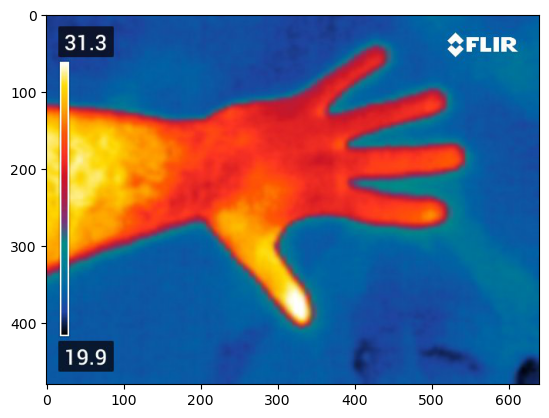

In [11]:
plt.imshow(img1)

#### Preprocessed Image

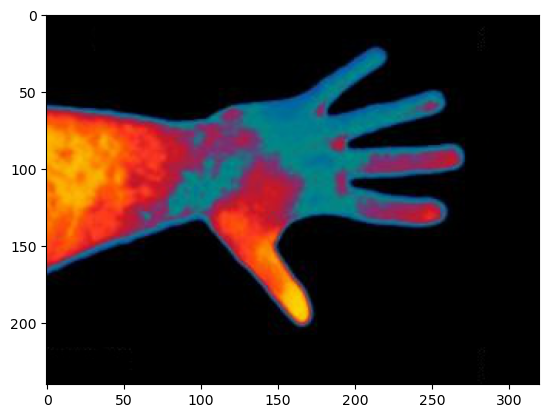

In [12]:
plt.imshow(img2)

## Pretrained Model and Transformation

In [13]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

Using cache found in C:\Users\LENOVO/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\LENOVO\anaconda3\envs\VR\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\VR\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
layers = list(pretrained_model.children())[:-1]
maxpool = torch.nn.MaxPool2d(6, stride = 1)
avgpool = torch.nn.AvgPool2d(6, stride = 1)
flatten = torch.nn.Flatten()
layers.append(avgpool)
# layers.append(flatten)
pretrained_model = torch.nn.Sequential(*layers)
pretrained_model.to('cpu')
pretrained_model.eval()
pretrained_model

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

## Dataset Creation

#### Extracting Dataset

In [16]:
def get_data(csv_path, imagepath, pretrained_model, trans, Labels, SBP, DBP, extra_feat):
    data_df = pd.read_csv(csv_path)

    for _, row in data_df.iterrows():
        pth = imagepath + str(row['Index']) + '.jpg'
        if os.path.isfile(pth)  is False:
            continue
        image = Image.open(pth)
        image = trans(image).unsqueeze(0)
        feature = pretrained_model(image).detach().numpy()
        Labels.append(feature)
        SBP.append(row['SBP'])
        DBP.append(row['DBP'])
        extra_feat.append([row['Weight'], row['Height'], row['Age']])

    return Labels, SBP, DBP, extra_feat

In [17]:
images18path = 'IIITB Dataset/18C_processed/'
images20path = 'IIITB Dataset/20C_processed/'
images22path = 'IIITB Dataset/22C_processed/'
vios_img_path = 'VIOS/ViosImagesProcessed/'

In [18]:
images18csvpath = 'IIITB Dataset/18C.csv'
images20csvpath = 'IIITB Dataset/20C.csv'
images22csvpath = 'IIITB Dataset/22C.csv'
vios_csv18_path = 'VIOS/18C.csv'
vios_csv20_path = 'VIOS/20C.csv'
vios_csv22_path = 'VIOS/22C.csv'

In [19]:
Labels = []
SBP = []
DBP = []
extra_feat = []

In [20]:
Labels, SBP, DBP, extra_feat = get_data(images18csvpath, images18path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)
Labels, SBP, DBP, extra_feat = get_data(images20csvpath, images20path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)
Labels, SBP, DBP, extra_feat = get_data(images22csvpath, images22path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)
Labels, SBP, DBP, extra_feat = get_data(vios_csv18_path, vios_img_path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)
Labels, SBP, DBP, extra_feat = get_data(vios_csv20_path, vios_img_path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)
Labels, SBP, DBP, extra_feat = get_data(vios_csv22_path, vios_img_path, pretrained_model, trans, Labels, SBP, DBP, extra_feat)

In [21]:
Labels[0].shape

(1, 2208, 2, 2)

#### Preprocessing Dataset for Model

In [22]:
SBP = np.array(SBP)
DBP = np.array(DBP)
extra_feat = np.array([np.array(i) for i in extra_feat], dtype=np.float32)
ss = StandardScaler()
extra_feat = ss.fit_transform(extra_feat)

In [23]:
out = np.append(SBP.reshape(-1, 1), DBP.reshape(-1, 1), axis=1)
out = np.append(out, extra_feat, axis = 1)
out.shape

(946, 5)

#### Train Test Validation Split

In [24]:
train_x, test_x, train_y, test_y = train_test_split(Labels, out, shuffle = True, test_size=0.3, random_state=42)
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, shuffle = True, test_size=0.5, random_state=42)

#### Dataloaders

In [25]:
class thermalDataset(Dataset):
  def __init__(self, features, sbp, dbp, extra_feat):
      super().__init__()
      self.features = features
      self.sbp = sbp 
      self.dbp = dbp
      self.extra_feat = extra_feat

  def __len__(self):
    return len(self.features)

  def __getitem__(self, indx):
    retsbp = np.float32(self.sbp[indx] / 180.00)
    retdbp = np.float32(self.dbp[indx] / 180.00)
    ef = np.float32(self.extra_feat[indx])
    return {'feature': self.features[indx], 'sbp': retsbp, 'dbp': retdbp, 'ef': ef}

In [26]:
train_dataset = thermalDataset(train_x, train_y[..., 0].tolist(), train_y[..., 1].tolist(), train_y[..., 2:6])
test_dataset = thermalDataset(val_x, val_y[..., 0].tolist(), val_y[..., 1].tolist(), val_y[..., 2:6])
val_dataset = thermalDataset(test_x, test_y[..., 0].tolist(), test_y[..., 1].tolist(), test_y[..., 2:6])

In [27]:
train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = True)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = 16, shuffle = True)

## Stage 2: Deep Neural Network

In [28]:
class DeepNeuralNet(torch.nn.Module):

  def __init__(self):
    super(DeepNeuralNet, self).__init__()
    self.flatten = torch.nn.Flatten()

    self.l1 = torch.nn.Linear(8832, 1024, bias=True)
    self.l2 = torch.nn.Linear(1024, 512, bias=True)
    self.l3 = torch.nn.Linear(512, 256, bias=True)
    self.l4 = torch.nn.Linear(259, 128, bias=True)
    self.l5 = torch.nn.Linear(128, 1, bias=True)
    
    self.relu = torch.nn.ReLU()
    self.dr1 = torch.nn.Dropout(0.3)
    self.dr2 = torch.nn.Dropout(0.25)
    self.dr3 = torch.nn.Dropout(0.2)
    self.dr4 = torch.nn.Dropout(0.2)

  def forward1(self, features):
    features1 = self.flatten(features)
    features1 = self.dr1(self.relu(self.l1(features1)))
    features1 = self.dr2(self.relu(self.l2(features1)))
    features1 = self.dr3(self.relu(self.l3(features1)))

    return {'bp': features1}
  
  def forward2(self, features1):
    features1 = self.dr3(self.relu(self.l4(features1)))
    features1 = self.l5(features1)

    return {'bp': features1}
  
  def forward(self, features, extra_feat):
    features = self.forward1(features)['bp']
    features = torch.cat((features, extra_feat), dim=1)
    features = self.forward2(features)
    return features

## Training Process

In [126]:
def training(model, hyperparameters, train_data_loader, val_data_loader, device):
    epochs = hyperparameters["num_epochs"]
    learning_rate = hyperparameters["lr"]
    momentum = hyperparameters["momentum"]

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = torch.nn.L1Loss()  
    maeLoss = torch.nn.L1Loss()
    
    trainSBPLoss = []
    valSBPLoss = []

    trainSBPMAE = []
    valSBPMAE = []

    model.train()

    for epoch in range(epochs):
        trainloss = 0.0
        valLoss = 0.0

        trainsbpLoss = 0.0
        valsbpLoss = 0.0

        trainsbpmae = 0.0
        valsbpmae = 0.0

        model.train()

        for _, sample in enumerate(train_data_loader):
            feature, sbp, extra_feat = sample['feature'].to(device), sample['sbp'].to(device), sample['ef'].to(device)
            optimizer.zero_grad()
            output = model(feature, extra_feat)
            sbp = sbp.unsqueeze(1)
        
            sbpLoss = criterion(output['bp'], sbp)

            sbpmae = maeLoss(output['bp'], sbp)

            loss = sbpLoss
            trainsbpmae += sbpmae.item()
            trainloss += loss.item()
            trainsbpLoss += sbpLoss.item()

            sbpLoss.backward(retain_graph=True)
            optimizer.step() 

        trainSBPMAE.append(trainsbpmae/len(train_x))
        trainSBPLoss.append(trainsbpLoss/len(train_x))

        model.eval()
        with torch.no_grad():
            for _, sample in enumerate(val_data_loader):
                feature, sbp, extra_feat = sample['feature'].to(device), sample['sbp'].to(device), sample['ef'].to(device)
                output = model(feature, extra_feat)
                sbp = sbp.unsqueeze(1)
                sbpLoss = criterion(output['bp'], sbp) 
                loss = sbpLoss
                sbpmae = maeLoss(output['bp'], sbp)

                valLoss += loss.item()
                valsbpmae += sbpmae.item()
                valsbpLoss += sbpLoss.item()

        valSBPLoss.append(valsbpLoss/len(val_x))
        valSBPMAE.append(valsbpmae/len(val_x))
    
        if(epoch+1)%100==0 :print("Epoch:", epoch+1, "| TrainLoss:", trainloss, "| ValLoss:", valLoss)
    
    return model, trainSBPLoss, valSBPLoss, trainSBPMAE, valSBPMAE

In [127]:
hyperparameters = {
    "num_epochs": 3000,
    "lr": 0.0014,
    "momentum": 0.95
}

In [128]:
model = DeepNeuralNet()

In [129]:
# model, trainSBPLoss, valSBPLoss, trainSBPMAE, valSBPMAE = training(model.to(device), hyperparameters, train_data_loader, val_data_loader, device)

Epoch: 100 | TrainLoss: 0.7087128162384033 | ValLoss: 0.18337255530059338
Epoch: 200 | TrainLoss: 0.5368000231683254 | ValLoss: 0.1926189474761486
Epoch: 300 | TrainLoss: 0.4146498814225197 | ValLoss: 0.15989344380795956
Epoch: 400 | TrainLoss: 0.38607910834252834 | ValLoss: 0.13810180872678757
Epoch: 500 | TrainLoss: 0.39505567215383053 | ValLoss: 0.13683902006596327
Epoch: 600 | TrainLoss: 0.3625937420874834 | ValLoss: 0.1362195797264576
Epoch: 700 | TrainLoss: 0.319595446344465 | ValLoss: 0.14700067602097988
Epoch: 800 | TrainLoss: 0.29579297080636024 | ValLoss: 0.12401123763993382
Epoch: 900 | TrainLoss: 0.3044574670493603 | ValLoss: 0.11867698282003403
Epoch: 1000 | TrainLoss: 0.2761306851170957 | ValLoss: 0.11471479386091232
Epoch: 1100 | TrainLoss: 0.29008936882019043 | ValLoss: 0.12349271215498447
Epoch: 1200 | TrainLoss: 0.2620270154438913 | ValLoss: 0.12412494095042348
Epoch: 1300 | TrainLoss: 0.3104069805704057 | ValLoss: 0.13561569340527058
Epoch: 1400 | TrainLoss: 0.290048

In [175]:
sbps = []
outputsbps = []

model.eval()

with torch.no_grad():
  for batch_idx, sample in enumerate(test_data_loader):
    feature, sbp, extra_feat = sample['feature'].to(device), sample['sbp'].to(device), sample['ef'].to(device)
    output = model(feature, extra_feat)
    sbps.append(sbp.unsqueeze(1))
    outputsbps.append(output['bp'])

In [176]:
sbp = sbps[0]
outputsbp = outputsbps[0]

for i in range(1,len(sbps)):
  sbp = torch.cat((sbp, sbps[i]))
  outputsbp = torch.cat((outputsbp, outputsbps[i]))

In [177]:
# Calculates Mean Absolute % error
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output)*100.0 / target))

def MAE(output, target):
  return torch.mean(torch.abs(target-output)*180.0)

def stdError(output, target):
  return torch.std((target-output)*180.0)

In [178]:
print("MAPE for SBP: ", MAPELoss(outputsbp, sbp))
print("MAE for SBP: ", MAE(outputsbp, sbp))
print("Standard deviation SBP: ", stdError(outputsbp, sbp))

MAPE for SBP:  tensor(1.3934, device='cuda:0')
MAE for SBP:  tensor(1.6417, device='cuda:0')
Standard deviation SBP:  tensor(2.8872, device='cuda:0')


## Testing pipeline

#### IMPORTING BEST SAVED MODELS

In [192]:
sbp_model = torch.load("finalbestsbp.pth")
dbp_model = torch.load("finalbestdbp.pth")

In [195]:
sbp_model.eval()
dbp_model.eval()

DeepNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=8832, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=256, bias=True)
  (l4): Linear(in_features=259, out_features=128, bias=True)
  (l5): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dr1): Dropout(p=0.3, inplace=False)
  (dr2): Dropout(p=0.25, inplace=False)
  (dr3): Dropout(p=0.2, inplace=False)
  (dr4): Dropout(p=0.2, inplace=False)
)

In [210]:
class pipeline():
    def __init__(self, pretrained_model, image_trans, standard_scale, deep_neural):
        self.stage_1 = pretrained_model
        self.stage_2 = deep_neural
        self.image_trans = image_trans
        self.standard_scale = standard_scale

    def preprocess(self, image, extra_feat):
        extra_feat = torch.from_numpy(self.standard_scale.transform(extra_feat.reshape(1, -1)))
        image = self.image_trans(image).unsqueeze(0)
        return image, extra_feat
    
    def stage1(self, image):
        features = self.stage_1(image)
        return features

    def stage2(self, features, extra_feat):
        prediction = self.stage_2(features, extra_feat)
        return prediction

    def pipeline_prediction(self, image, extra_feat):
        image, extra_feat = self.preprocess(image, extra_feat)
        features = self.stage1(image)
        prediction = self.stage2(features, extra_feat)
        return prediction        

In [211]:
sbp_pipeline = pipeline(pretrained_model, trans, ss, sbp_model)
dbp_pipeline = pipeline(pretrained_model, trans, ss, dbp_model)

In [212]:
train18df = pd.read_csv("IIITB Dataset/18C.csv")

In [244]:
test_img_data = train18df.iloc[0]

In [245]:
test_image = Image.open("IIITB Dataset/18C_processed/" + test_img_data["Index"] + ".jpg")
sbp = test_img_data["SBP"]/180.0
dbp = test_img_data["DBP"]/180.0
extra_feat = np.array([test_img_data["Weight"], test_img_data["Height"], test_img_data["Age"]],dtype=np.float32)

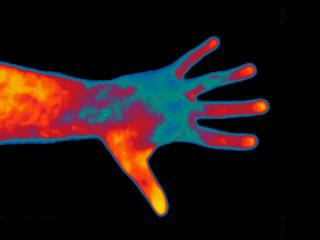

In [246]:
test_image

In [247]:
sbp_prediction = sbp_pipeline.pipeline_prediction(test_image, extra_feat)["bp"]
dbp_prediction = dbp_pipeline.pipeline_prediction(test_image, extra_feat)["bp"]

In [248]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output)*100.0 / target))

def MAE(output, target):
  return torch.mean(torch.abs(target-output)*180.0)

def stdError(output, target):
  return torch.std((target-output)*180.0)

In [249]:
print("Error for SBP:", MAE(sbp_prediction, sbp).detach().numpy(), "mmHg")
print("Error for DBP:", MAE(dbp_prediction, dbp).detach().numpy(), "mmHg")

Error for SBP: 0.23109913 mmHg
Error for DBP: 0.5368978 mmHg
